In [52]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 

In [53]:
customer_data=pd.read_csv('Customers.csv')
product_data=pd.read_csv('Products.csv')
transaction_data=pd.read_csv("Transactions - Transactions.csv")

exploring the features of each dataset

In [54]:
customer_data.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [55]:
product_data.head()

,ProductID,ProductName,Category,Price
0,P001,ActiveWear Biography,Books,169.30
1,P002,ActiveWear Smartwatch,Electronics,346.30
2,P003,ComfortLiving Biography,Books,44.12
3,P004,BookWorld Rug,Home Decor,95.69
4,P005,TechPro T-Shirt,Clothing,429.31


In [58]:
transaction_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 7:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [60]:
len(product_data),len(customer_data),len(transaction_data)

(100, 200, 1000)

check for any missing or null values, exploring datatype of the object

In [61]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.3+ KB


In [62]:
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB


In [63]:
transaction_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
 7   category         1000 non-null   object 
 8   region           1000 non-null   object 
dtypes: float64(2), int64(1), object(6)
memory usage: 70.4+ KB


observation : there is no missing or null values, the datasets given has already cleaned

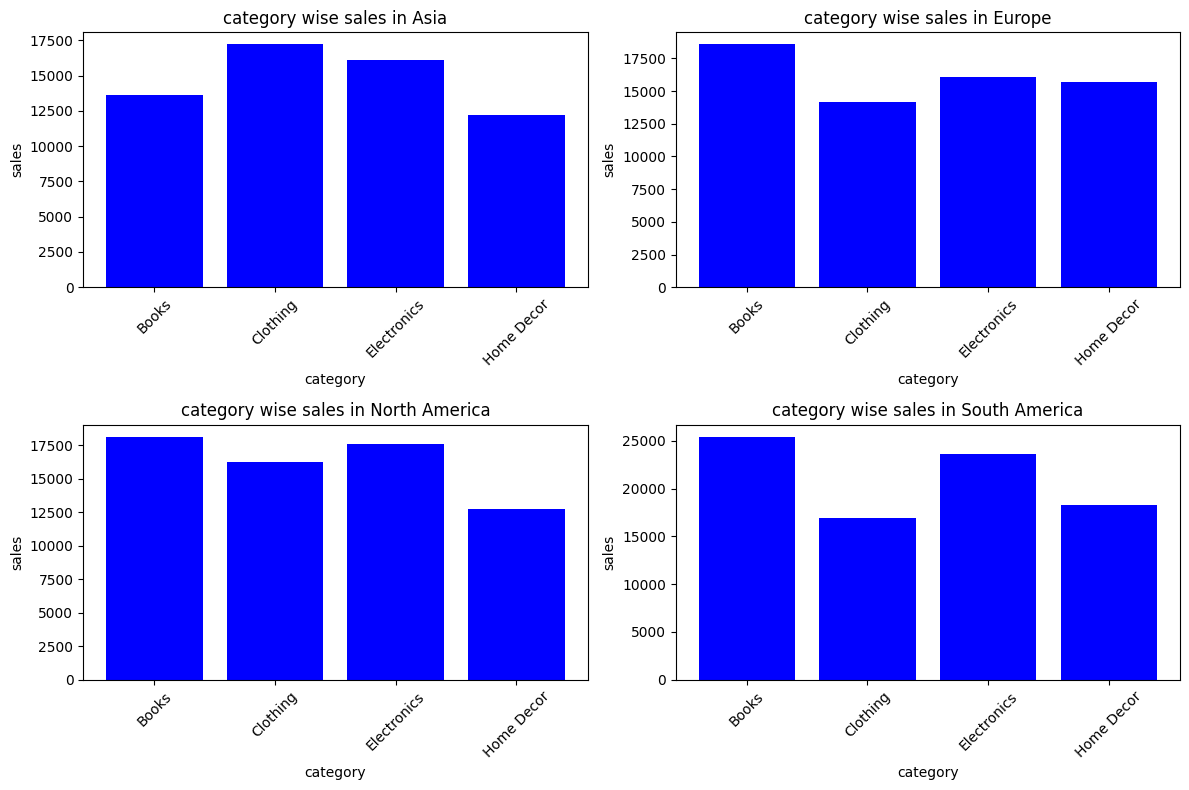

In [59]:
transaction_data['TransactionDate']=transaction_data['TransactionDate'].apply(lambda x: pd.to_datetime(x))

transaction_data_=transaction_data
transaction_data_.set_index('TransactionID',inplace=True)

product_data_=product_data
product_data_=product_data_.set_index('ProductID')

category_product_map=dict(product_data.groupby('Category')['ProductID'].apply(set))
region_customer_map=dict(customer_data.groupby('Region')['CustomerID'].apply(set))
transaction_data['category'] = transaction_data['ProductID'].apply(
	lambda x: next((y for y in category_product_map if x in category_product_map[y]), None)
)
transaction_data['region']=transaction_data['CustomerID'].apply(
    lambda x: next((y for y in region_customer_map if x in region_customer_map[y]),None)
)
cate_region_sales = {
    region: group.groupby('category')['Price'].sum()
    for region, group in transaction_data.groupby('region')
}
fig,axes=plt.subplots(2,2,figsize=(12,8))
axes=axes.flatten()

for i,(region,sales_data) in enumerate(cate_region_sales.items()):
    ax=axes[i]
    ax.bar(sales_data.index,sales_data.values,color='blue')
    ax.set_title(f'category wise sales in {region}')
    ax.set_xlabel('category')
    ax.set_ylabel('sales')
    ax.set_xticks(range(len(sales_data.index)))
    ax.set_xticklabels(sales_data.index,rotation=45)


for j in range(i+1,len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

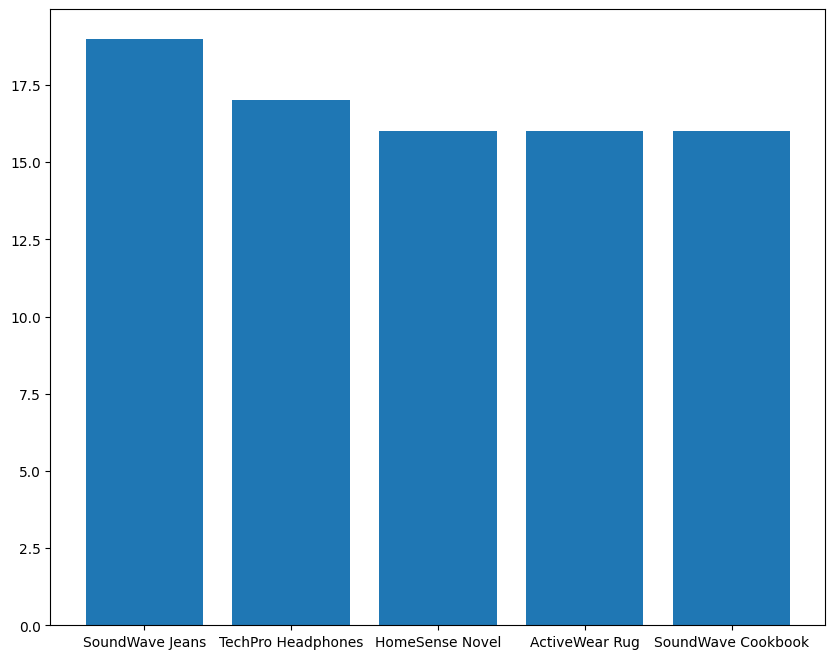

In [64]:
data = transaction_data.groupby('ProductID').size().reset_index(name='count')
data=data.sort_values(by='count',ascending=False)
data1 = pd.merge(data, product_data, on='ProductID', how='inner')
plt.figure(figsize=(10,8))
plt.bar(data1[:5]['ProductName'],data1[:5]['count'])
plt.show()  

In [66]:
import math

customer_aggregation = transaction_data.groupby('CustomerID')['ProductID'].apply(list).reset_index(name='Products')
customer_aggregation_trans=transaction_data.groupby('CustomerID')['TransactionID'].apply(list).reset_index(name='Transactions')
customer_aggregation_count=transaction_data.groupby('CustomerID')['Quantity'].apply(list).reset_index(name='Quantity')
cust=pd.merge(customer_aggregation,customer_aggregation_trans,on='CustomerID')
cust=pd.merge(cust,customer_aggregation_count,on='CustomerID')
cust = (
    transaction_data.groupby('CustomerID')
    .agg({
        'ProductID': list,
        'TransactionID': list,
        'Quantity':list
    })
    .reset_index()
    .rename(columns={'ProductID': 'Products', 'TransactionID': 'Transactions','Quantity':'Quantity'})
)
cust['NoOfTransactions']=cust['Transactions'].apply(lambda x:len(x))
cust['category']=cust['Products'].apply(lambda x:[product_data_['Category'][i] for i in x])
cust['products']=cust['Products'].apply(lambda x:[product_data_['ProductName'][i] for i in x])
cust=pd.merge(cust,customer_data,on='CustomerID',how='inner')
cust['amount'] = cust['Transactions'].apply(lambda x: sum([int(transaction_data_['Price'][i]) for i in x]))

cust['category'] = cust['category'].apply(lambda x: {i: x.count(i) for i in x})
cust['products']=cust['products'].apply(lambda x:{i:x.count(i) for i in x})
cust['Quantity']=cust['Quantity'].apply(lambda x:{i:x.count(i) for i in x} )

cust.drop(['Products','Transactions','CustomerName'],axis=1,inplace=True)

cust['AvgAmountPerTransaction'] = cust['amount'] / cust['NoOfTransactions']
cust['AvgQuantityPerTransaction']=cust['Quantity'].apply(lambda x:math.floor(sum([a*b for a,b in x.items()]) /sum(x.values())))
cust['FavouriteCategory'] = cust['category'].apply(
    lambda x: max(x.items(), key=lambda item: item[1])[0]
)
cust['FavouriteProduct'] = cust['products'].apply(
    lambda x: max(x.items(), key=lambda item: item[1])[0]
)

cust.head() 

,CustomerID,Quantity,NoOfTransactions,category,products,Region,SignupDate,amount,AvgAmountPerTransaction,AvgQuantityPerTransaction,FavouriteCategory,FavouriteProduct
0,C0001,"{2: 3, 3: 2}",5,"{'Books': 1, 'Home Decor': 1, 'Electronics': 3}","{'SoundWave Cookbook': 1, 'HomeSense Wall Art'...",South America,2022-07-10,1389,277.80,2,Electronics,SoundWave Cookbook
1,C0002,"{2: 3, 4: 1}",4,"{'Home Decor': 2, 'Clothing': 2}","{'BookWorld Cookware Set': 1, 'BookWorld Rug':...",Asia,2022-02-13,834,208.50,2,Home Decor,BookWorld Cookware Set
2,C0003,"{3: 2, 4: 2}",4,"{'Home Decor': 2, 'Clothing': 1, 'Electronics'...","{'ActiveWear Cookware Set': 1, 'ActiveWear Rug...",South America,2024-03-07,781,195.25,3,Home Decor,ActiveWear Cookware Set
3,C0004,"{4: 3, 3: 2, 2: 2, 1: 1}",8,"{'Books': 3, 'Home Decor': 3, 'Electronics': 2}","{'TechPro Textbook': 1, 'TechPro Rug': 1, 'Tec...",South America,2022-10-09,1920,240.00,2,Books,TechPro Textbook
4,C0005,"{3: 1, 2: 2}",3,"{'Home Decor': 1, 'Electronics': 2}","{'ActiveWear Cookware Set': 1, 'TechPro Smartw...",Asia,2022-08-15,873,291.00,2,Electronics,ActiveWear Cookware Set


saving the combined table for building lookalike model and clustering

In [75]:
cust.to_csv('cust.csv')

In [67]:
avg_transactions = cust['NoOfTransactions'].mean()
max_transactions = cust['NoOfTransactions'].max()
avg_amount,max_amount,min_amount=cust['amount'].mean(),cust['amount'].max(),cust['amount'].min()
print(f"Average Transactions: {avg_transactions}, Max Transactions: {max_transactions}")
print(f'average {int(avg_amount)}, max {max_amount}, min {min_amount}')


Average Transactions: 5.025125628140704, Max Transactions: 11
average 1367, max 3852, min 41


In [68]:
region_wise_amount = dict(cust.groupby('Region')['amount'].sum())
region_wise_amount

{'Asia': 59036,
 'Europe': 64365,
 'North America': 64602,
 'South America': 84064}

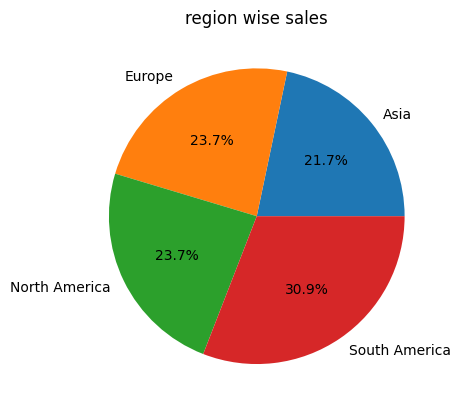

In [69]:
plt.pie(region_wise_amount.values(), labels=region_wise_amount.keys(), autopct='%1.1f%%')
plt.title("region wise sales")
plt.show()

In [70]:
region_wise_customer_count=dict(cust.groupby('Region')['CustomerID'].count())
print(region_wise_customer_count)

{'Asia': 44, 'Europe': 50, 'North America': 46, 'South America': 59}


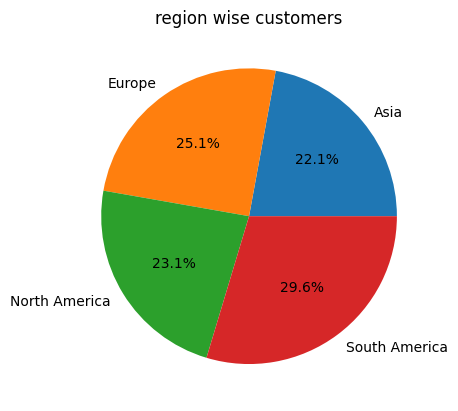

In [71]:
plt.pie(region_wise_customer_count.values(), labels=region_wise_customer_count.keys(), autopct='%1.1f%%')
plt.title('region wise customers')
plt.show()

In [72]:
product_data['Category'].unique()

array(['Books', 'Electronics', 'Home Decor', 'Clothing'], dtype=object)

In [73]:
category_wize_sales=dict(transaction_data.groupby('category')['TotalValue'].apply(sum))
category_wize_sales


C:\Users\Vasantha Raj\AppData\Local\Temp\ipykernel_9920\2307501563.py:1: FutureWarning: The provided callable <built-in function sum> is currently using np.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string np.sum instead.
  category_wize_sales=dict(transaction_data.groupby('category')['TotalValue'].apply(sum))


{'Books': 192147.47000000003,
 'Clothing': 166170.66,
 'Electronics': 180783.5,
 'Home Decor': 150893.93}

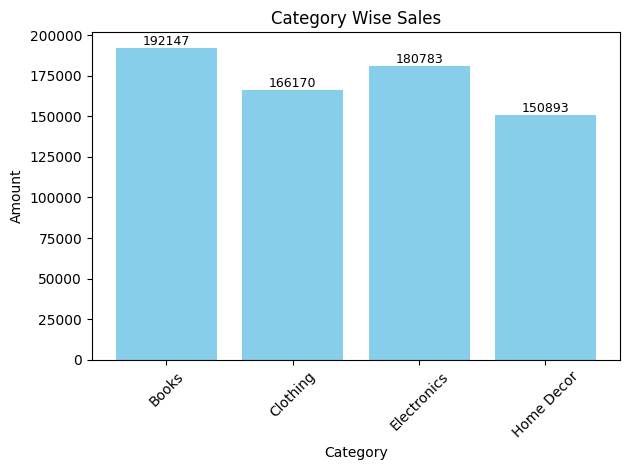

In [74]:
plt.bar(category_wize_sales.keys(), category_wize_sales.values(), color='skyblue')
plt.title('Category Wise Sales')
plt.xlabel('Category')
plt.ylabel('Amount')
for i, value in enumerate(category_wize_sales.values()):
    plt.text(i, value + 10,  
             str(int(value)),     
             ha='center',   
             va='bottom',    
             fontsize=9)    

plt.xticks(rotation=45) 
plt.tight_layout()       
plt.show()